### Just a simple classification model with TensorFlow
---

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import datasets, preprocessing, model_selection
%matplotlib inline
seed = 1
np.set_printoptions(precision=5, suppress=True)

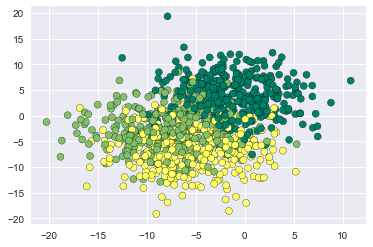

In [2]:
# Let's create and visualize our 'toy' dataset
X, Y = datasets.make_blobs(n_samples=1000,
                           n_features=2,
                           centers=3,
                           cluster_std=4,
                           center_box=(-8,8),
                           random_state=seed)

plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.summer, edgecolor='k')
plt.show()

In [3]:
encoder = preprocessing.OneHotEncoder().fit(np.unique(Y).reshape(-1,1))
encoded_Y = encoder.transform(Y.reshape(-1,1)).toarray()

In [4]:
trainX, testX, trainY, testY = model_selection.train_test_split(X, encoded_Y, test_size=0.2, random_state=seed)

In [5]:
# Hyperparams for the network
learning_rate = 0.01
input_dim = trainX.shape[1]
output_dim = trainY.shape[1]
n_hidden = 4
batch_size = 50
num_batches = len(trainX)//batch_size
epochs = 500

x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='input')
y = tf.placeholder(dtype=tf.float32, shape=[None, output_dim], name='output')

In [6]:
tf.set_random_seed(seed)

# Variables for the network
weights = {'w1': tf.Variable(tf.random_normal([input_dim, n_hidden])),
           'w_out': tf.Variable(tf.random_normal([n_hidden, output_dim]))}

biases = {'b1': tf.Variable(tf.random_normal([n_hidden])),
          'b_out': tf.Variable(tf.random_normal([output_dim]))}

In [7]:
def neural_network(x):
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_2 = tf.add(tf.matmul(layer_1, weights['w_out']), biases['b_out'])
    layer_out = tf.nn.relu(layer_2)
    return layer_out

In [8]:
logits = neural_network(x)

In [9]:
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=logits)

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

In [11]:
accuracy = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

In [12]:
train_loss = []
train_accuracy = []
test_accuracy = []

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(epochs):
    if (epoch+1) % 100 == 0:
        print('Epoch: {:3d}'.format(epoch+1))
        print('-'*20)
    
    shuffle = True
    if shuffle:
        idx = np.arange(0, len(trainX))
        np.random.shuffle(idx)
        trainX = np.array([trainX[i] for i in idx])
        trainY = np.array([trainY[i] for i in idx])
        
    for i in range(num_batches):
        start = i * batch_size
        end = i * batch_size + batch_size
        batchX = trainX[start:end]
        batchY = trainY[start:end]
        
        _, _loss, _logit, _acc = sess.run([train_op, loss, logits, accuracy], feed_dict={x: batchX,
                                                                                         y: batchY})
        train_loss.append(_loss)
        train_accuracy.append(_acc)
        
        _acc_test = sess.run([accuracy], feed_dict={x: testX,
                                                    y: testY})
        test_accuracy.append(_acc_test)
        

train_eval = sess.run(accuracy, feed_dict={x: trainX, y: trainY})
test_eval = sess.run(accuracy, feed_dict={x: testX, y: testY})

print('\nTraining Accuracy:\t{:5.2f}'.format(train_eval))
print('Test Accuracy:\t\t{:5.2f}'.format(test_eval))

Epoch: 100
--------------------
Epoch: 200
--------------------
Epoch: 300
--------------------
Epoch: 400
--------------------
Epoch: 500
--------------------

Training Accuracy:	 0.71
Test Accuracy:		 0.70


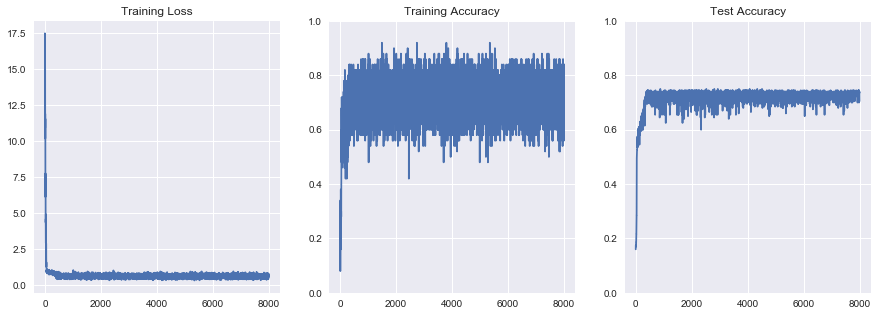

In [13]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(train_loss)
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy)
ax[1].set_ylim([0,1])
ax[1].set_title('Training Accuracy')

ax[2].plot(test_accuracy)
ax[2].set_ylim([0,1])
ax[2].set_title('Test Accuracy')

plt.show()

In [14]:
# Confusion matrix
(pd.DataFrame(metrics.confusion_matrix(y_true=np.argmax(testY,axis=1),
                                       y_pred=sess.run(tf.argmax(logits, axis=1),
                                                       feed_dict={x: testX}))))

,0,1,2
0,60,4,1
1,10,36,25
2,10,9,45


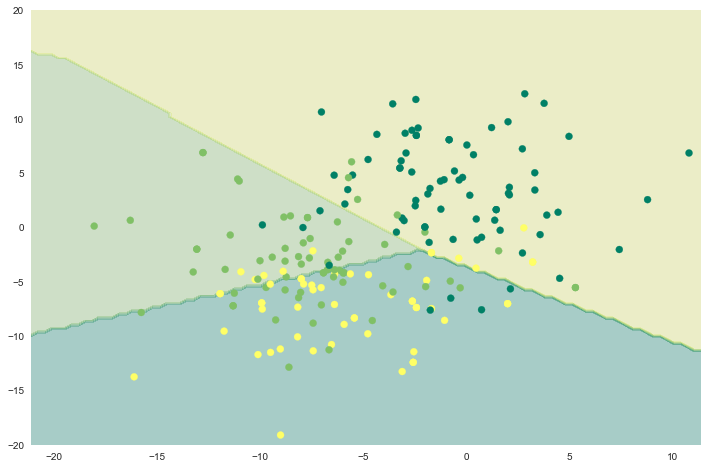

In [15]:
# Decision boundary
x_min, x_max = X[:,0].min()-0.9, X[:,0].max()+0.9
y_min, y_max = X[:,1].min()-0.9, X[:,1].max()+0.9

spacing = min(x_max-x_min, y_max-y_min) / 100

XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                     np.arange(y_min, y_max, spacing))

points = np.hstack((XX.ravel().reshape(-1,1),
                    YY.ravel().reshape(-1,1)))

clf = np.argmax(sess.run(logits, {x: points}), axis=1)

Z = clf.reshape(XX.shape)

plt.figure(figsize=(12,8))
plt.contourf(XX, YY, Z, cmap=plt.cm.summer_r, alpha=0.3)

# Select some random points from the original data to plot
selected = np.random.randint(low=0, high=1000, size=200)

plt.scatter(X[selected,0], X[selected,1], c=Y[selected], cmap=plt.cm.summer, alpha=1)
plt.grid('off')
plt.show()